In [4]:
# coding: utf-8
# 2021/3/23 @ tongshiwei
import logging
from EduCDM import CIRT
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import random
import numpy as np

train_data = pd.read_csv("../../../data/a0910/train.csv")
valid_data = pd.read_csv("../../../data/a0910/valid.csv")
test_data = pd.read_csv("../../../data/a0910/test.csv")

batch_size = 256
sample_size = 3


def transform(x, y, z, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)


def transform_train_data(x, y, z, f, p, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32),
        torch.tensor(f, dtype=torch.int64),
        torch.tensor(p, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)


def fake_train_data(train_data, valid_data, test_data, s):
    all_data = pd.concat([train_data, valid_data, test_data], axis=0)
    existing_all_users = all_data['user_id'].unique()
    existing_train_users = train_data['user_id'].unique()
    new_train_data = []
    for train_user in existing_train_users:
        user_data = train_data[train_data['user_id'] == train_user]

        num_rows = len(user_data)
        if num_rows < s:
            random_rows = list(range(num_rows))
            s = num_rows
        else:
            random_rows = random.sample(range(num_rows), s)

        fake_user_ids = []
        for _ in range(s):
            fake_user_id = max(existing_all_users) + 1
            while fake_user_id in existing_all_users:
                fake_user_id += 1
            existing_all_users = np.append(existing_all_users, fake_user_id)
            fake_user_ids.append(fake_user_id)

        pos = [(user_data.iloc[i]['score'] - 0.5) * 2 for i in random_rows]
        row_count = 0
        for index, row in user_data.iterrows():
            user_id = row['user_id']
            item_id = row['item_id']
            score = row['score']

            data_point = {
                'user_id': user_id,
                'item_id': item_id,
                'score': score,
                'user_id_pair': fake_user_ids,
                'pos': pos,
                'fake': 0
            }
            new_train_data.append(data_point)

            for i in range(s):   
                if row_count == random_rows[i]:
                    fake_score = 1 - score
                    fake_data_point = {
                        'user_id': fake_user_id[i],
                        'item_id': item_id,
                        'score': fake_score,
                        'user_id_pair': [user_id],
                        'pos': [- pos[i]],
                        'fake': 1
                    }
                    new_train_data.append(fake_data_point)
                else:
                    fake_data_point = {
                        'user_id': fake_user_id[i],
                        'item_id': item_id,
                        'score': score,
                        'user_id_pair': [user_id],
                        'pos': [- pos[i]],
                        'fake': 1
                    }
                    new_train_data.append(fake_data_point)
            row_count += 1

    new_train_data_df = pd.DataFrame(new_train_data)
    shuffled_data = new_train_data_df.sample(frac=1).reset_index(drop=True)
    return shuffled_data, max(existing_all_users)


valid, test = [
    transform(data["user_id"], data["item_id"], data["score"], batch_size)
    for data in [valid_data, test_data]
]

train_data, user_num = fake_train_data(train_data, valid_data, test_data, sample_size)
train = transform_train_data(train_data["user_id"], train_data["item_id"], train_data["score"], train_data["user_id_pair"], train_data["pos"], batch_size)
# print(train_data["pos"])
# print(max(train_data['user_id'].unique()))

logging.getLogger().setLevel(logging.INFO)

# print(user_num)
cdm = CIRT(user_num + 1, 17747)

cdm.train(train, valid, epoch=18)
cdm.save("irt.params")

cdm.load("irt.params")
rmse, mae, auc, accuracy = cdm.eval(test)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))


Epoch 0: 100%|██████████| 1454/1454 [00:12<00:00, 115.25it/s]


[Epoch 0] LogisticLoss: 1.187448


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.19it/s]


[Epoch 0] rmse: 0.504811, mae: 0.410266, auc: 0.536118, accuracy: 0.635476


Epoch 1: 100%|██████████| 1454/1454 [00:12<00:00, 117.39it/s]


[Epoch 1] LogisticLoss: 1.108175


evaluating: 100%|██████████| 101/101 [00:00<00:00, 264.44it/s]


[Epoch 1] rmse: 0.494511, mae: 0.404069, auc: 0.564055, accuracy: 0.646919


Epoch 2: 100%|██████████| 1454/1454 [00:12<00:00, 118.77it/s]


[Epoch 2] LogisticLoss: 1.046474


evaluating: 100%|██████████| 101/101 [00:00<00:00, 214.81it/s]


[Epoch 2] rmse: 0.485729, mae: 0.398311, auc: 0.590334, accuracy: 0.657229


Epoch 3: 100%|██████████| 1454/1454 [00:12<00:00, 117.39it/s]


[Epoch 3] LogisticLoss: 0.996776


evaluating: 100%|██████████| 101/101 [00:00<00:00, 243.02it/s]


[Epoch 3] rmse: 0.478413, mae: 0.393132, auc: 0.613749, accuracy: 0.664766


Epoch 4: 100%|██████████| 1454/1454 [00:11<00:00, 122.14it/s]


[Epoch 4] LogisticLoss: 0.957587


evaluating: 100%|██████████| 101/101 [00:00<00:00, 291.54it/s]


[Epoch 4] rmse: 0.472436, mae: 0.388580, auc: 0.633701, accuracy: 0.669257


Epoch 5: 100%|██████████| 1454/1454 [00:10<00:00, 140.41it/s]


[Epoch 5] LogisticLoss: 0.926050


evaluating: 100%|██████████| 101/101 [00:00<00:00, 294.42it/s]


[Epoch 5] rmse: 0.467609, mae: 0.384618, auc: 0.650030, accuracy: 0.674842


Epoch 6: 100%|██████████| 1454/1454 [00:10<00:00, 140.90it/s]


[Epoch 6] LogisticLoss: 0.900025


evaluating: 100%|██████████| 101/101 [00:00<00:00, 287.47it/s]


[Epoch 6] rmse: 0.463742, mae: 0.381158, auc: 0.663060, accuracy: 0.678083


Epoch 7: 100%|██████████| 1454/1454 [00:10<00:00, 141.54it/s]


[Epoch 7] LogisticLoss: 0.879282


evaluating: 100%|██████████| 101/101 [00:00<00:00, 299.50it/s]


[Epoch 7] rmse: 0.460646, mae: 0.378126, auc: 0.673387, accuracy: 0.680973


Epoch 8: 100%|██████████| 1454/1454 [00:10<00:00, 140.92it/s]


[Epoch 8] LogisticLoss: 0.861688


evaluating: 100%|██████████| 101/101 [00:00<00:00, 282.57it/s]


[Epoch 8] rmse: 0.458158, mae: 0.375443, auc: 0.681631, accuracy: 0.684683


Epoch 9: 100%|██████████| 1454/1454 [00:10<00:00, 142.19it/s]


[Epoch 9] LogisticLoss: 0.846917


evaluating: 100%|██████████| 101/101 [00:00<00:00, 294.45it/s]


[Epoch 9] rmse: 0.456144, mae: 0.373059, auc: 0.688248, accuracy: 0.686206


Epoch 10: 100%|██████████| 1454/1454 [00:10<00:00, 141.20it/s]


[Epoch 10] LogisticLoss: 0.834576


evaluating: 100%|██████████| 101/101 [00:00<00:00, 291.89it/s]


[Epoch 10] rmse: 0.454509, mae: 0.370932, auc: 0.693579, accuracy: 0.687183


Epoch 11: 100%|██████████| 1454/1454 [00:10<00:00, 141.77it/s]


[Epoch 11] LogisticLoss: 0.823549


evaluating: 100%|██████████| 101/101 [00:00<00:00, 232.56it/s]


[Epoch 11] rmse: 0.453180, mae: 0.369030, auc: 0.697949, accuracy: 0.689018


Epoch 12: 100%|██████████| 1454/1454 [00:10<00:00, 141.85it/s]


[Epoch 12] LogisticLoss: 0.814369


evaluating: 100%|██████████| 101/101 [00:00<00:00, 279.16it/s]


[Epoch 12] rmse: 0.452097, mae: 0.367325, auc: 0.701540, accuracy: 0.691713


Epoch 13: 100%|██████████| 1454/1454 [00:10<00:00, 137.27it/s]


[Epoch 13] LogisticLoss: 0.806521


evaluating: 100%|██████████| 101/101 [00:00<00:00, 272.77it/s]


[Epoch 13] rmse: 0.451215, mae: 0.365796, auc: 0.704505, accuracy: 0.693002


Epoch 14: 100%|██████████| 1454/1454 [00:10<00:00, 135.31it/s]


[Epoch 14] LogisticLoss: 0.799132


evaluating: 100%|██████████| 101/101 [00:00<00:00, 272.65it/s]


[Epoch 14] rmse: 0.450496, mae: 0.364422, auc: 0.706982, accuracy: 0.694837


Epoch 15: 100%|██████████| 1454/1454 [00:10<00:00, 134.69it/s]


[Epoch 15] LogisticLoss: 0.792706


evaluating: 100%|██████████| 101/101 [00:00<00:00, 272.27it/s]


[Epoch 15] rmse: 0.449911, mae: 0.363186, auc: 0.709048, accuracy: 0.696438


Epoch 16: 100%|██████████| 1454/1454 [00:10<00:00, 132.52it/s]


[Epoch 16] LogisticLoss: 0.786893


evaluating: 100%|██████████| 101/101 [00:00<00:00, 285.70it/s]


[Epoch 16] rmse: 0.449434, mae: 0.362073, auc: 0.710785, accuracy: 0.697258


Epoch 17: 100%|██████████| 1454/1454 [00:10<00:00, 133.41it/s]


[Epoch 17] LogisticLoss: 0.781393


evaluating: 100%|██████████| 101/101 [00:00<00:00, 281.60it/s]
INFO:root:save parameters to irt.params
INFO:root:load parameters from irt.params


[Epoch 17] rmse: 0.449054, mae: 0.361075, auc: 0.712234, accuracy: 0.697376


evaluating: 100%|██████████| 218/218 [00:00<00:00, 290.28it/s]

rmse: 0.450114, mae: 0.362632, auc: 0.713181, accuracy: 0.694871


In [2]:
import sys
sys.path.append('../../../')

import logging
from EduCDM import CIRT
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import random
import numpy as np


cdm = CIRT(6622, 17747)
cdm.load("irt.params")

/data/zhengz/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the data from files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("../../../data/a0910/train.csv")
valid_data = pd.read_csv("../../../data/a0910/valid.csv")
test_data = pd.read_csv("../../../data/a0910/test.csv")
data = pd.concat([train_data, valid_data, test_data], axis=0)
# print("User:", len(data['UserId'].unique()))
# print("Question:", len(data['QuestionId'].unique()))

# user_max = max(data['UserId'].unique())
# question_max = max(data['QuestionId'].unique())
# print(user_max)
# print(question_max)
batch_size = 256
def transform(x, y, z, batch_size, **params):
    x = x.to_numpy()
    y = y.to_numpy()
    z = z.to_numpy()
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)

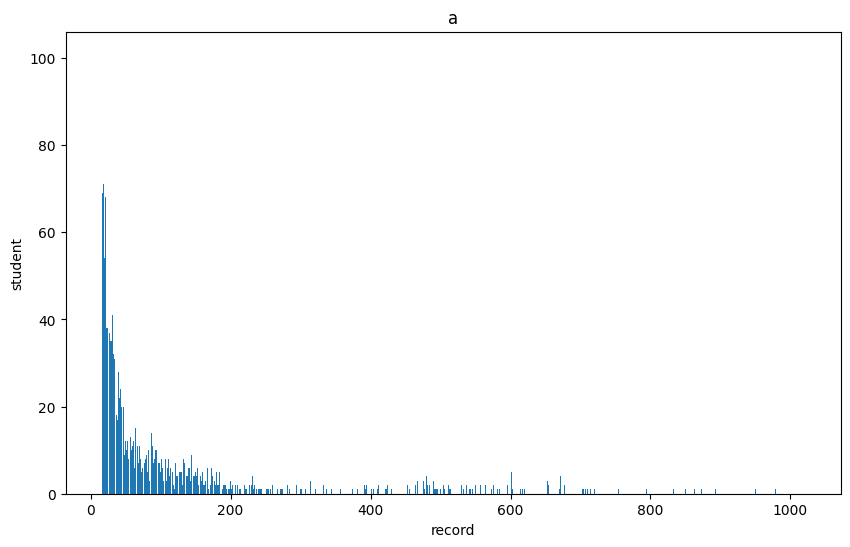

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# user_records_count = data['user_id'].value_counts().sort_values(ascending=False)
# user_records_count.head(15)
# user_records_count.to_csv('../../../data/a0910/user_records_count.csv', index=True)

user_records_count = pd.read_csv("../../../data/a0910/user_records_count.csv")
user_count = user_records_count["count"].value_counts().sort_index()
# user_count.to_csv("../../../data/a0910/user_count.csv")

plt.figure(figsize=(10, 6))
plt.bar(user_count.index, user_count.values)
plt.xlabel('record')
plt.ylabel('student')
plt.title('a')
plt.show()

In [5]:
test_data = pd.read_csv('../../../data/a0910/test.csv')
user_records_count = pd.read_csv('../../../data/a0910/user_records_count.csv')
test_data = test_data.merge(user_records_count, on='user_id', how='inner')

test1_data = test_data[test_data['count'] < 200]
test2_data = test_data[test_data['count'] >= 200]

test1, test2 = [
    transform(data["user_id"], data["item_id"], data["score"], batch_size)
    for data in [test1_data, test2_data]
]
test1, test2

(<torch.utils.data.dataloader.DataLoader at 0x7f335dc3a260>,
 <torch.utils.data.dataloader.DataLoader at 0x7f335dc39ea0>)

In [6]:
cdm.load("irt.params")
rmse, mae, auc, accuracy = cdm.eval(test1)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))

evaluating: 100%|██████████| 104/104 [00:00<00:00, 432.07it/s]

rmse: 0.465881, mae: 0.384276, auc: 0.705418, accuracy: 0.671155


In [7]:
cdm.load("irt.params")
rmse, mae, auc, accuracy = cdm.eval(test2)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))

evaluating: 100%|██████████| 115/115 [00:00<00:00, 484.64it/s]

rmse: 0.435326, mae: 0.343010, auc: 0.716776, accuracy: 0.716371


In [2]:
# coding: utf-8
# 2021/3/23 @ tongshiwei
import logging
from EduCDM import CIRT
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import random
import numpy as np

train_data = pd.read_csv("../../../data/a0910/train.csv")
valid_data = pd.read_csv("../../../data/a0910/valid.csv")
test_data = pd.read_csv("../../../data/a0910/test.csv")

batch_size = 256


def transform(x, y, z, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)


def transform_train_data(x, y, z, f, p, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32),
        torch.tensor(f, dtype=torch.int64),
        torch.tensor(p, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)


def fake_train_data(train_data, valid_data, test_data):
    all_data = pd.concat([train_data, valid_data, test_data], axis=0)
    existing_all_users = all_data['user_id'].unique()
    existing_train_users = train_data['user_id'].unique()
    # print(max(existing_all_users))
    new_train_data = []
    for train_user in existing_train_users:
        user_data = train_data[train_data['user_id'] == train_user]
        fake_user_id = max(existing_all_users) + 1
        while fake_user_id in existing_all_users:
            fake_user_id = fake_user_id + 1
        existing_all_users = np.append(existing_all_users, fake_user_id)

        num_rows = len(user_data)
        random_row = random.randint(0, num_rows - 1)
        pos = (user_data.iloc[random_row]['score'] - 0.5) * 2
        # print(pos)
        row_count = 0
        for index, row in user_data.iterrows():
            user_id = row['user_id']
            item_id = row['item_id']
            score = row['score']
            data_point = {
                'user_id': user_id,
                'item_id': item_id,
                'score': score,
                'user_id_pair': fake_user_id,  # 记录原始 user_id
                'pos': pos,  # 记录是否伪造为反话
                'fake': 1
            }
            new_train_data.append(data_point)

            if row_count == random_row:
                fake_score = 1 - score
            else:
                fake_score = score
            row_count += 1
            fake_data_point = {
                'user_id': fake_user_id,
                'item_id': item_id,
                'score': fake_score,
                'user_id_pair': user_id,
                'pos': (0 - pos),
                'fake': 1
            }
            new_train_data.append(fake_data_point)

    new_train_data_df = pd.DataFrame(new_train_data)
    shuffled_data = new_train_data_df.sample(frac=1).reset_index(drop=True)
    return shuffled_data, max(existing_all_users)


valid, test = [
    transform(data["user_id"], data["item_id"], data["score"], batch_size)
    for data in [valid_data, test_data]
]

train_data, user_num = fake_train_data(train_data, valid_data, test_data)

train_data.to_csv("../../../data/a0910/fake_train.csv", index=False)

In [4]:
# coding: utf-8
# 2021/3/23 @ tongshiwei
import logging
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import random
import numpy as np

train_data = pd.read_csv('../../../data/a0910/fake_train.csv')
user_records_count = pd.read_csv('../../../data/a0910/user_records_count.csv')

# 将 user_records_count 转换成字典
user_records_dict = dict(zip(user_records_count['user_id'], user_records_count['count']))

# 定义函数来根据条件设置 group 列的值
def set_group(row):
    if row['user_id'] in user_records_dict:
        if user_records_dict[row['user_id']] >= 200:
            return 1
        else:
            return 0
    elif row['user_id_pair'] in user_records_dict:
        if user_records_dict[row['user_id_pair']] >= 200:
            return 1
        else:
            return 0
    else:
        return None  # 可以根据实际情况设置默认值

# 应用函数来设置 group 列的值
train_data['group'] = train_data.apply(set_group, axis=1)


def set_fake(row):
    if row['user_id'] in user_records_dict:
        return 0
    elif row['user_id_pair'] in user_records_dict:
        return 1
    else:
        return None  # 可以根据实际情况设置默认值

train_data['fake'] = train_data.apply(set_fake, axis=1)

# train_data.to_csv('../../data/public_data/train_data/fake_train.csv', index=False)


In [5]:
def transform_train_data(x, y, z, f, p, fake, g, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32),
        torch.tensor(f, dtype=torch.int64),
        torch.tensor(p, dtype=torch.float32),
        torch.tensor(fake, dtype=torch.int64),
        torch.tensor(g, dtype=torch.int64)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)

batch_size = 256
train = transform_train_data(train_data["user_id"], train_data["item_id"], train_data["score"], train_data["user_id_pair"], train_data["pos"], train_data["fake"], train_data["group"], batch_size)
# print(train_data["pos"])
# print(max(train_data['user_id'].unique()))

In [6]:
from EduCDM import GCIRT
import logging

logging.getLogger().setLevel(logging.INFO)


user_num = max(train_data["user_id"].unique())
# print(user_num)

cdm = GCIRT(6622, 17747)

cdm.train(train, valid, epoch=35)
cdm.save("gcirt.params")

Epoch 0:   0%|          | 0/1454 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 1454/1454 [00:17<00:00, 81.48it/s] 


[Epoch 0] LogisticLoss: 0.979303


evaluating: 100%|██████████| 101/101 [00:00<00:00, 270.92it/s]


[Epoch 0] rmse: 0.504724, mae: 0.417061, auc: 0.527956, accuracy: 0.632625


Epoch 1: 100%|██████████| 1454/1454 [00:15<00:00, 93.32it/s]


[Epoch 1] LogisticLoss: 0.917447


evaluating: 100%|██████████| 101/101 [00:00<00:00, 259.69it/s]


[Epoch 1] rmse: 0.495504, mae: 0.413074, auc: 0.551269, accuracy: 0.642154


Epoch 2: 100%|██████████| 1454/1454 [00:15<00:00, 94.70it/s]


[Epoch 2] LogisticLoss: 0.867268


evaluating: 100%|██████████| 101/101 [00:00<00:00, 262.68it/s]


[Epoch 2] rmse: 0.487168, mae: 0.408918, auc: 0.574705, accuracy: 0.648559


Epoch 3: 100%|██████████| 1454/1454 [00:15<00:00, 91.92it/s]


[Epoch 3] LogisticLoss: 0.826290


evaluating: 100%|██████████| 101/101 [00:00<00:00, 273.66it/s]


[Epoch 3] rmse: 0.479797, mae: 0.404718, auc: 0.597230, accuracy: 0.655237


Epoch 4: 100%|██████████| 1454/1454 [00:15<00:00, 92.29it/s]


[Epoch 4] LogisticLoss: 0.792796


evaluating: 100%|██████████| 101/101 [00:00<00:00, 268.17it/s]


[Epoch 4] rmse: 0.473416, mae: 0.400583, auc: 0.617963, accuracy: 0.663555


Epoch 5: 100%|██████████| 1454/1454 [00:15<00:00, 92.77it/s]


[Epoch 5] LogisticLoss: 0.764670


evaluating: 100%|██████████| 101/101 [00:00<00:00, 246.68it/s]


[Epoch 5] rmse: 0.467996, mae: 0.396605, auc: 0.636228, accuracy: 0.669101


Epoch 6: 100%|██████████| 1454/1454 [00:15<00:00, 92.72it/s]


[Epoch 6] LogisticLoss: 0.741079


evaluating: 100%|██████████| 101/101 [00:00<00:00, 233.37it/s]


[Epoch 6] rmse: 0.463455, mae: 0.392844, auc: 0.651809, accuracy: 0.675310


Epoch 7: 100%|██████████| 1454/1454 [00:15<00:00, 92.43it/s]


[Epoch 7] LogisticLoss: 0.721182


evaluating: 100%|██████████| 101/101 [00:00<00:00, 225.24it/s]


[Epoch 7] rmse: 0.459676, mae: 0.389321, auc: 0.664915, accuracy: 0.680622


Epoch 8: 100%|██████████| 1454/1454 [00:15<00:00, 92.76it/s]


[Epoch 8] LogisticLoss: 0.704576


evaluating: 100%|██████████| 101/101 [00:00<00:00, 216.61it/s]


[Epoch 8] rmse: 0.456531, mae: 0.386034, auc: 0.675845, accuracy: 0.685152


Epoch 9: 100%|██████████| 1454/1454 [00:15<00:00, 94.26it/s]


[Epoch 9] LogisticLoss: 0.690676


evaluating: 100%|██████████| 101/101 [00:00<00:00, 271.04it/s]


[Epoch 9] rmse: 0.453909, mae: 0.382970, auc: 0.684943, accuracy: 0.688315


Epoch 10: 100%|██████████| 1454/1454 [00:15<00:00, 94.69it/s]


[Epoch 10] LogisticLoss: 0.678153


evaluating: 100%|██████████| 101/101 [00:00<00:00, 261.32it/s]


[Epoch 10] rmse: 0.451721, mae: 0.380115, auc: 0.692495, accuracy: 0.691244


Epoch 11: 100%|██████████| 1454/1454 [00:15<00:00, 94.82it/s]


[Epoch 11] LogisticLoss: 0.667547


evaluating: 100%|██████████| 101/101 [00:00<00:00, 267.79it/s]


[Epoch 11] rmse: 0.449893, mae: 0.377456, auc: 0.698764, accuracy: 0.692377


Epoch 12: 100%|██████████| 1454/1454 [00:15<00:00, 93.95it/s] 


[Epoch 12] LogisticLoss: 0.657974


evaluating: 100%|██████████| 101/101 [00:00<00:00, 265.56it/s]


[Epoch 12] rmse: 0.448364, mae: 0.374980, auc: 0.703964, accuracy: 0.693900


Epoch 13: 100%|██████████| 1454/1454 [00:15<00:00, 93.72it/s]


[Epoch 13] LogisticLoss: 0.649801


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.50it/s]


[Epoch 13] rmse: 0.447089, mae: 0.372675, auc: 0.708345, accuracy: 0.696165


Epoch 14: 100%|██████████| 1454/1454 [00:16<00:00, 89.86it/s]


[Epoch 14] LogisticLoss: 0.642532


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.44it/s]


[Epoch 14] rmse: 0.446028, mae: 0.370531, auc: 0.712048, accuracy: 0.697180


Epoch 15: 100%|██████████| 1454/1454 [00:16<00:00, 87.43it/s]


[Epoch 15] LogisticLoss: 0.635727


evaluating: 100%|██████████| 101/101 [00:00<00:00, 211.81it/s]


[Epoch 15] rmse: 0.445145, mae: 0.368537, auc: 0.715192, accuracy: 0.698742


Epoch 16: 100%|██████████| 1454/1454 [00:16<00:00, 87.78it/s]


[Epoch 16] LogisticLoss: 0.629885


evaluating: 100%|██████████| 101/101 [00:00<00:00, 262.65it/s]


[Epoch 16] rmse: 0.444408, mae: 0.366680, auc: 0.717894, accuracy: 0.700227


Epoch 17: 100%|██████████| 1454/1454 [00:16<00:00, 87.45it/s]


[Epoch 17] LogisticLoss: 0.624573


evaluating: 100%|██████████| 101/101 [00:00<00:00, 261.57it/s]


[Epoch 17] rmse: 0.443791, mae: 0.364948, auc: 0.720258, accuracy: 0.701945


Epoch 18: 100%|██████████| 1454/1454 [00:16<00:00, 87.04it/s]


[Epoch 18] LogisticLoss: 0.620322


evaluating: 100%|██████████| 101/101 [00:00<00:00, 212.27it/s]


[Epoch 18] rmse: 0.443273, mae: 0.363331, auc: 0.722345, accuracy: 0.703585


Epoch 19: 100%|██████████| 1454/1454 [00:16<00:00, 87.21it/s]


[Epoch 19] LogisticLoss: 0.615321


evaluating: 100%|██████████| 101/101 [00:00<00:00, 188.46it/s]


[Epoch 19] rmse: 0.442838, mae: 0.361818, auc: 0.724195, accuracy: 0.704405


Epoch 20: 100%|██████████| 1454/1454 [00:16<00:00, 87.51it/s]


[Epoch 20] LogisticLoss: 0.611284


evaluating: 100%|██████████| 101/101 [00:00<00:00, 211.95it/s]


[Epoch 20] rmse: 0.442473, mae: 0.360400, auc: 0.725834, accuracy: 0.705850


Epoch 21: 100%|██████████| 1454/1454 [00:16<00:00, 88.39it/s]


[Epoch 21] LogisticLoss: 0.607647


evaluating: 100%|██████████| 101/101 [00:00<00:00, 205.25it/s]


[Epoch 21] rmse: 0.442174, mae: 0.359069, auc: 0.727310, accuracy: 0.706944


Epoch 22: 100%|██████████| 1454/1454 [00:16<00:00, 87.43it/s]


[Epoch 22] LogisticLoss: 0.604253


evaluating: 100%|██████████| 101/101 [00:00<00:00, 242.59it/s]


[Epoch 22] rmse: 0.441933, mae: 0.357817, auc: 0.728601, accuracy: 0.706944


Epoch 23: 100%|██████████| 1454/1454 [00:16<00:00, 87.06it/s]


[Epoch 23] LogisticLoss: 0.601149


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.00it/s]


[Epoch 23] rmse: 0.441743, mae: 0.356639, auc: 0.729750, accuracy: 0.707295


Epoch 24: 100%|██████████| 1454/1454 [00:16<00:00, 87.92it/s]


[Epoch 24] LogisticLoss: 0.598291


evaluating: 100%|██████████| 101/101 [00:00<00:00, 254.68it/s]


[Epoch 24] rmse: 0.441596, mae: 0.355530, auc: 0.730781, accuracy: 0.707647


Epoch 25: 100%|██████████| 1454/1454 [00:16<00:00, 86.40it/s]


[Epoch 25] LogisticLoss: 0.595634


evaluating: 100%|██████████| 101/101 [00:00<00:00, 259.99it/s]


[Epoch 25] rmse: 0.441486, mae: 0.354484, auc: 0.731698, accuracy: 0.708037


Epoch 26: 100%|██████████| 1454/1454 [00:16<00:00, 87.24it/s]


[Epoch 26] LogisticLoss: 0.593187


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.08it/s]


[Epoch 26] rmse: 0.441407, mae: 0.353495, auc: 0.732542, accuracy: 0.707803


Epoch 27: 100%|██████████| 1454/1454 [00:16<00:00, 85.62it/s]


[Epoch 27] LogisticLoss: 0.590916


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.11it/s]


[Epoch 27] rmse: 0.441353, mae: 0.352560, auc: 0.733305, accuracy: 0.708662


Epoch 28: 100%|██████████| 1454/1454 [00:16<00:00, 86.87it/s]


[Epoch 28] LogisticLoss: 0.588779


evaluating: 100%|██████████| 101/101 [00:00<00:00, 222.84it/s]


[Epoch 28] rmse: 0.441320, mae: 0.351674, auc: 0.734012, accuracy: 0.708389


Epoch 29: 100%|██████████| 1454/1454 [00:16<00:00, 85.80it/s]


[Epoch 29] LogisticLoss: 0.586773


evaluating: 100%|██████████| 101/101 [00:00<00:00, 251.22it/s]


[Epoch 29] rmse: 0.441304, mae: 0.350832, auc: 0.734663, accuracy: 0.708935


Epoch 30: 100%|██████████| 1454/1454 [00:16<00:00, 88.05it/s]


[Epoch 30] LogisticLoss: 0.584896


evaluating: 100%|██████████| 101/101 [00:00<00:00, 237.75it/s]


[Epoch 30] rmse: 0.441303, mae: 0.350032, auc: 0.735267, accuracy: 0.709404


Epoch 31: 100%|██████████| 1454/1454 [00:16<00:00, 86.27it/s]


[Epoch 31] LogisticLoss: 0.583142


evaluating: 100%|██████████| 101/101 [00:00<00:00, 201.31it/s]


[Epoch 31] rmse: 0.441316, mae: 0.349269, auc: 0.735822, accuracy: 0.710185


Epoch 32: 100%|██████████| 1454/1454 [00:16<00:00, 87.13it/s]


[Epoch 32] LogisticLoss: 0.581465


evaluating: 100%|██████████| 101/101 [00:00<00:00, 257.03it/s]


[Epoch 32] rmse: 0.441342, mae: 0.348543, auc: 0.736321, accuracy: 0.710458


Epoch 33: 100%|██████████| 1454/1454 [00:16<00:00, 86.11it/s]


[Epoch 33] LogisticLoss: 0.579886


evaluating: 100%|██████████| 101/101 [00:00<00:00, 260.66it/s]


[Epoch 33] rmse: 0.441380, mae: 0.347850, auc: 0.736792, accuracy: 0.710458


Epoch 34: 100%|██████████| 1454/1454 [00:16<00:00, 87.56it/s]


[Epoch 34] LogisticLoss: 0.578380


evaluating: 100%|██████████| 101/101 [00:00<00:00, 260.01it/s]
INFO:root:save parameters to gcirt.params


[Epoch 34] rmse: 0.441429, mae: 0.347189, auc: 0.737221, accuracy: 0.710576


In [7]:
cdm.load("gcirt.params")
rmse, mae, auc, accuracy = cdm.eval(test)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))

INFO:root:load parameters from gcirt.params
evaluating: 100%|██████████| 218/218 [00:01<00:00, 146.90it/s]


rmse: 0.441838, mae: 0.348250, auc: 0.738256, accuracy: 0.710151


In [8]:
batch_size = 256
def transform(x, y, z, batch_size, **params):
    x = x.to_numpy()
    y = y.to_numpy()
    z = z.to_numpy()
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)


test_data = pd.read_csv('../../../data/a0910/test.csv')
user_records_count = pd.read_csv('../../../data/a0910/user_records_count.csv')
test_data = test_data.merge(user_records_count, on='user_id', how='inner')

test1_data = test_data[test_data['count'] < 200]
test2_data = test_data[test_data['count'] >= 200]

test1, test2 = [
    transform(data["user_id"], data["item_id"], data["score"], batch_size)
    for data in [test1_data, test2_data]
]
test1, test2

(<torch.utils.data.dataloader.DataLoader at 0x20ca8f90220>,
 <torch.utils.data.dataloader.DataLoader at 0x20ca182a2b0>)

In [9]:
cdm.load("gcirt.params")
rmse, mae, auc, accuracy = cdm.eval(test1)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))

cdm.load("gcirt.params")
rmse, mae, auc, accuracy = cdm.eval(test2)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))

INFO:root:load parameters from gcirt.params
evaluating: 100%|██████████| 104/104 [00:00<00:00, 150.92it/s]
INFO:root:load parameters from gcirt.params


rmse: 0.458429, mae: 0.366197, auc: 0.726190, accuracy: 0.688919


evaluating: 100%|██████████| 115/115 [00:00<00:00, 140.45it/s]

rmse: 0.426239, mae: 0.331980, auc: 0.747980, accuracy: 0.729399


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import random
import numpy as np

train_data = pd.read_csv("../../../data/a0910/3_fake_train.csv")
batch_size = 64

def transform_train_data(x, y, z, f, p, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32),
        torch.tensor(f, dtype=torch.int64),
        torch.tensor(p, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)

user_id_pair = []
pos = []
for i, s in train_data.iterrows():
    codes1 = eval(s['user_id_pair'])
    codes2 = eval(s['pos'])
    user_id_pair.append(codes1)
    pos.append(codes2)
    
train = transform_train_data(train_data["user_id"], train_data["item_id"], train_data["score"], user_id_pair, pos, batch_size)

# 创建一个迭代器
iterator = iter(train)

# 获取第一个元素
user_id, item_id, response, user_id_pair, pos = next(iterator)

# 打印 user_id_pair 的形状
print(user_id_pair.shape)


/data/zhengz/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([64, 3])


In [5]:
# coding: utf-8
# 2021/3/23 @ tongshiwei
import sys
sys.path.append("../../..")

import logging
from EduCDM import CIRT
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import random
import numpy as np

batch_size = 256
sample_size = 3

train_data = pd.read_csv("../../../data/a0910/" + str(sample_size) + "_fake_train.csv")
valid_data = pd.read_csv("../../../data/a0910/valid.csv")
test_data = pd.read_csv("../../../data/a0910/test.csv")



def transform(x, y, z, batch_size, **params):
    dataset = TensorDataset(
        torch.tensor(x, dtype=torch.int64),
        torch.tensor(y, dtype=torch.int64),
        torch.tensor(z, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, **params)



valid, test = [
    transform(data["user_id"], data["item_id"], data["score"], batch_size)
    for data in [valid_data, test_data]
]

# print(train_data["pos"])
# print(max(train_data['user_id'].unique()))

logging.getLogger().setLevel(logging.INFO)

user_num = max(train_data['user_id'].unique())
# print(user_num)
cdm = CIRT(user_num + 1, 17747)

cdm.train(train, valid, epoch=18)
cdm.save("irt3.params")

cdm.load("irt3.params")
rmse, mae, auc, accuracy = cdm.eval(test)
print("rmse: %.6f, mae: %.6f, auc: %.6f, accuracy: %.6f" % (rmse, mae, auc, accuracy))


Epoch 0:   0%|          | 0/11629 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)